# TP5 Naive Bayes : Spam or not-spam


### Table of Contents

* [0. Data preparation](#chapter0)
* [1. Feature engineering : Text --> Vector](#chapter1)
* [2. Naive Bayes classifier](#chapter2)
* [3. Naive Bayes on MNIST and CIFAR10](#chapter3)


## 0. Data preparation <a class="anchor" id="chapter0"></a>

We want to be able to  predict if an e-mail is a  "spam" or not. We will use the dataset `spam`.

Reference : the dataset `spam` is taken from https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

First step : import the dataset 

In [2]:
sms = pd.read_csv("data/spam.csv", encoding="latin")

sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In column `v1`, `ham`= "non-spam". First we will rename the  columns `v1` and `v2` :  `v1`$\rightarrow$ ` Label ` and `v2`$\rightarrow$ `Texte`.

In [3]:
sms.rename(columns={"v1": "Label", "v2": "Text"}, inplace=True)

Let us check : 

In [4]:
sms.head()

,Label,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Next we create a new column, named `Labelnum` that contains zeros and ones :  `ham`$\rightarrow$ ` 0 ` and `spam`$\rightarrow$ ` 1 `.

In [5]:
sms["Labelnum"] = sms["Label"].map({"ham": 0, "spam": 1})

sms.head()

,Label,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4,Labelnum
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,1
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,0


**Exercice 1** : Display the sample size, the number of  hams and the number of spams. You can use the three next cells that contain hints (or not...). 

In [6]:
# Hint 1 for Exercise 1
a = np.array([0, 1, 1, 1, 0])
print(len(a))
print(a[a == 0])
print(len(a[a == 0]))
print(a[a == 1])
print(len(a[a == 1]))

5
[0 0]
2
[1 1 1]
3


In [7]:
# Hint 2 for Exercise 1
sms[sms.Labelnum == 0].head()

,Label,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4,Labelnum
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,0
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,0
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,0
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN,0


In [8]:
# Hint 3 for Exercise 1
sms[sms.Labelnum == 1].head()

,Label,Text,Unnamed: 2,Unnamed: 3,Unnamed: 4,Labelnum
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN,1
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN,1
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",NaN,NaN,NaN,1


In [9]:
print(len(sms))
print(sms[sms.Label == "ham"].shape)
print(sms[sms.Label == "spam"].shape)

5572
(4825, 6)
(747, 6)


 **Exercise 2** : (**Optional**) To get an overall view of the data, we can plot a histogram of the length of each SMS.

Hint 1 : How to access an SMS in the data? We can use
`pandas.DataFrame.loc`. Voir https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html

Hint 2: How to create a histogram ? https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.hist.html

In [10]:
# Hint 1  for Exercise 2
print(sms.loc[0, "Text"])
print("--> The length of the first sms is", len(sms.loc[0, "Text"]))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
--> The length of the first sms is 111


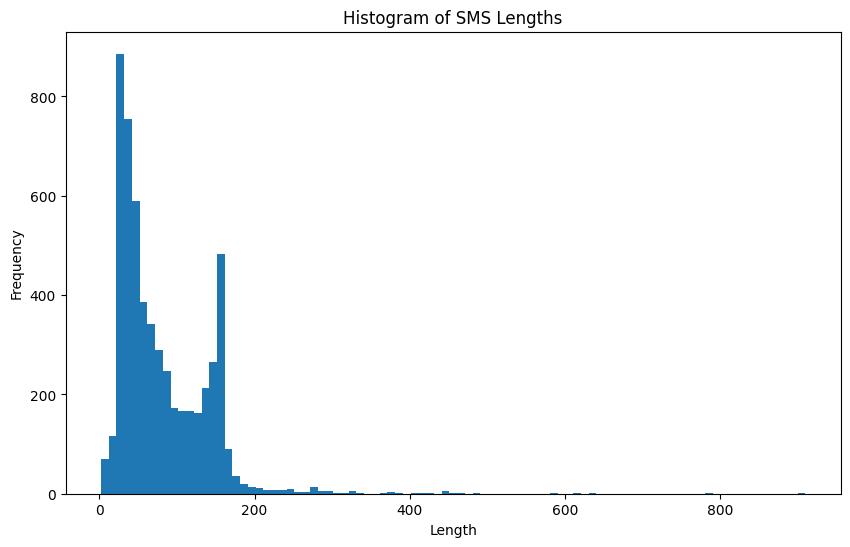

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(
    sms.loc[:, "Text"].apply(len),
    bins="stone",
)
plt.title("Histogram of SMS Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

-------------------------------------

## 1. Feature engineering : Text --> Vector <a class="anchor" id="chapter1"></a>


In this part, we will transform the text contained in an sms into a  numerical vector in $\mathbb{R}^{p}$. For this we will use `CountVectorizer`.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html



In [12]:
from sklearn.feature_extraction.text import CountVectorizer

---------------------------------

Let us first give an example of use of  `CountVectorizer`.

In [13]:
Example = pd.DataFrame(
    [
        ["iphone gratuit iphone gratuit", 1],
        ["mille vert gratuit", 0],
        ["iphone mille euro", 0],
        ["argent gratuit euro gratuit", 1],
    ],
    columns=["sms", "label"],
)
vec = CountVectorizer()
X = vec.fit_transform(Example.sms)

# 1. Displaying the vocabulary

print("1. The vocabulary of Example is ", vec.vocabulary_)

# 1 bis  :

print(
    "The vocabulary arranged in alphabetical order :  ",
    sorted(list(vec.vocabulary_.keys())),
)

# 2. Displaying the vectors :

print(
    "2. The vectors corresponding to the sms are :  \n", X.toarray()
)  # X.toarray because
# X is a "sparse" matrix.

# 3. For a new data x_0="iphone gratuit",
# you must also transform x_0 into a numerical vector before predicting.

vec_x_0 = vec.transform(["iphone gratuit"]).toarray()  #
print("3. The numerical vector corresponding to  (x_0=iphone gratuit) is \n", vec_x_0)

1. The vocabulary of Example is  {'iphone': 3, 'gratuit': 2, 'mille': 4, 'vert': 5, 'euro': 1, 'argent': 0}
The vocabulary arranged in alphabetical order :   ['argent', 'euro', 'gratuit', 'iphone', 'mille', 'vert']
2. The vectors corresponding to the sms are :  
 [[0 0 2 2 0 0]
 [0 0 1 0 1 1]
 [0 1 0 1 1 0]
 [1 1 2 0 0 0]]
3. The numerical vector corresponding to  (x_0=iphone gratuit) is 
 [[0 0 1 1 0 0]]


In [14]:
#'sparse' version  (without "to_array")
v = vec.transform(["iphone iphone gratuit"])
v

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2 stored elements and shape (1, 6)>

In [15]:
v.toarray()

array([[0, 0, 1, 2, 0, 0]])

In [16]:
# "(0,2)  1"  means :  the element in row 0 and column 2 is equal to 1.
# "(0,3)  2"  means : the element in row 0 and column 3 is equal to  2.
print(v)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 2 stored elements and shape (1, 6)>
  Coords	Values
  (0, 2)	1
  (0, 3)	2


**Exercise 3** :

1. Transform  $x_1=$ "iphone vert gratuit" into a numerical vector adapted to the vocabulary created with `Example`. 

2. Do the same with $x_2=$ "iphone rouge gratuit". What do you observe ?  

In [17]:
vec_x_1 = vec.transform(["iphone vert gratuit"]).toarray()
vec_x_2 = vec.transform(["iphone rouge gratuit"]).toarray()
print(vec_x_1)
print(vec_x_2)

[[0 0 1 1 0 1]]
[[0 0 1 1 0 0]]


-------------------------------------

Let us now go back to our original dataset `sms`. Maintenant on va changer les données `sms.Texte` en vecteur et les attribuer à `X`. De plus, on va attribuer `sms.Labelnum` au `Y`.



**Exercise 4** : Create a text-to-vector transformation model, named vectorizer. Train vectorizer on the sms.Text data.

Note: We have already imported the CountVectorizer package.

In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(sms["Text"])
y = sms["Labelnum"]

Next we split the sample into a training set and a test set. 

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=50
)

print("size of the training set: ", X_train.shape[0])
print("size of the test set :", X_test.shape[0])

size of the training set:  3900
size of the test set : 1672


------------------------------

## 2. Naive Bayes classification <a class="anchor" id="chapter2"></a>

Now we will train a Naive Bayes classification model. The class we will use is MultinomialNB from sklearn.naive_bayes.

Reference : https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

In [20]:
from sklearn.naive_bayes import MultinomialNB

**Exercise 6** : 

1. Create a Naive Bayes classification model with the smoothing parameter $\alpha$=1.0 (alpha=1.0), named `sms_bayes`.

What is the role of the smoothing parameter $\alpha$ ? Refer to the course or this page: https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes.
    
    

2. Fit `sms_bayes` on (`X_train, y_train`).

In [21]:
sms_bayes = MultinomialNB(alpha=1.0)
sms_bayes.fit(X_train, y_train)

MultinomialNB()

Let us look at the performance of  `sms_bayes` on the test set :

In [22]:
from sklearn.metrics import accuracy_score

y_pred = sms_bayes.predict(X_test)
print("The accuracy score on the test set is ", accuracy_score(y_test, y_pred))

The accuracy score on the test set is  0.9754784688995215


---------------------------


In **Exercise 1**, It was observed that in this SMS dataset, there are significantly more non-spam messages (4825) than spam messages (747). In this case, it is better to also check the confusion matrix.

Reference: Confusion Matrix
 https://fr.wikipedia.org/wiki/Matrice_de_confusion

In [23]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1410,   16],
       [  25,  221]])

**(Optional)**  

Test whether your SMS will be classified as spam or not. Replace `something new` in the next cell with your SMS.



In [24]:
my_sms = vectorizer.transform(
    [
        "free trial!",
        "Iphone 15 is now free",
        "I want coffee",
        "I want to buy a new iphone",
    ]
)

pred_my_sms = sms_bayes.predict(my_sms)
print(pred_my_sms)

[1 1 0 0]


## 2. Naive Bayes on MNIST and cifar-10 <a class="anchor" id="chapter3"></a>

We will implement Exercise 6.2 from the course handout. We will implement a Bernoulli Naive Bayes model instead of Multinomial Naive Bayes model.   For that, we will use  `BernoulliNB` in `sklearn.naive_bayes`. First let us deal with MNIST. 

In [25]:
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import BernoulliNB

# Load the MNIST dataset
mnist = fetch_openml("mnist_784", version=1, parser="auto")
X, y = mnist.data, mnist.target

**Exercise 7**
1. Convert pixel values to $\{0, 1\}$. The pixel values range from 0 to 256. All values above 127 are converted to 1, the others to 0. 

2. Split into training and test sets (25% for the test set and `random_state=42`). 

3. Initialize and train a Bernoulli Naive Bayes classifier. 

4. Make the predictions on the test set and compute the accuracy score. 

In [26]:
X_copy = (X.copy() >= 127).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X_copy, y, test_size=0.25, random_state=42
)

ber_bayes = BernoulliNB()
ber_bayes.fit(X_train, y_train)

y_pred = ber_bayes.predict(X_test)
accuracy_score(y_test, y_pred)

0.8375428571428571

For **cifar10**, we will do the same. First let us import the dataset. 

In [27]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [28]:
# reminder : the output is an RGB image 32 x 32
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


 We need to convert the RGB values into grayscale. For that we use `cvtColor` in the `cv2` package. You may need to install the library `opencv`. 

Remark : `cvtColor` takes an image and the output of cifar10.load_data is an image as well. 

In [29]:
# Convert images to grayscale
import cv2

x_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in x_train])
x_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in x_test])

**Exercise 8** Implement a Bernoulli Naive Bayes classifier on the grayscale images as we did for MNIST and compute the accuracy score on the test images. 

In [30]:
x_train_binarized = (x_train_gray > 127).astype(int)
x_test_binarized = (x_test_gray > 127).astype(int)

# Flatten the images into vectors of size 1024 (32x32)
x_train_flattened = x_train_binarized.reshape(x_train_binarized.shape[0], -1)
x_test_flattened = x_test_binarized.reshape(x_test_binarized.shape[0], -1)

# Initialize and train a Naive Bayes classifier
nb_classifier = BernoulliNB()
nb_classifier.fit(x_train_flattened, y_train.ravel())

# Make predictions on the test set
y_pred = nb_classifier.predict(x_test_flattened)

# Compute accuracy
accuracy = accuracy_score(y_test.ravel(), y_pred)
print(f"Naive Bayes Classification Accuracy: {accuracy:.4f}")

Naive Bayes Classification Accuracy: 0.2359


(**Optional**)If you want to know more about the conversion RGB to gray scale, the formula is as follows : 

Y = 0.299R + 0.587G + 0.114B

Where:

    Y is the resulting grayscale value

    R, G, and B are the red, green, and blue color channel values respectively

This formula, also known as the weighted method, takes into account the human eye's different sensitivities to red, green, and blue light. Green is given the highest weight (0.587) because the human eye is most sensitive to green light, followed by red (0.299), and then blue (0.114)